In [1]:
# Import a number is useful packages...
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from mpl_toolkits.mplot3d import Axes3D
from STUFF.poisson_disc import Grid
import random 

# CH273: Computational Workshop 2
## The radial distribution function

<img src="STUFF/gdr.png" width=400px>

In this session, we are going to play around with the radial distribution function, $g(r)$. As you may remember, the $g(r)$ represents the probability of finding a particle at a distance $r$ away from a given reference particle. Here, we are going to consider "a hard sphere liquid" (we are going to use the same Poisson-disc sampling we introduced in the previous Workshop), in two and three dimensions as well.

### The g(r) for a 2D system
We'll kick things off by generating a random configuration using exactly the same algorithm and syntax as what we have done in the previous workshop. We have to choose the length of our box (10 Å) as well as the minimum distance between the particles (0.6 Å).

In [2]:
# Set the length and width (the x and y dimensions) of the box
length = 10.0 # can be any units you like. A meaningful choice: [Å]
width = length # This is a square 2D box

# Set the minimum distance between the particles (as you can see, this is not really a hard sphere liquid! Why?)
min_r = 0.6 # [Å] 

# Generate a random arrangement of particles - according to an algorithm called Poisson sampling.
# Note that every time you run this cell, the algorithm will generate a DIFFERENT configuration!
grid = Grid(min_r, length, width)

# Random seed 
rand = (random.uniform(0, length), random.uniform(0, width))

# Do the sampling
data = np.array(grid.poisson(rand))
pos_x=np.array(data[:,0])
pos_y=np.array(data[:,1])

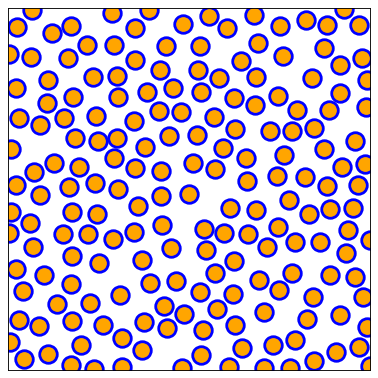

In [3]:
# Let's visualize the box and the particles - i.e. our hard sphere-ish liquid
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(pos_x,pos_y,s=250, facecolors='orange', edgecolors='blue',linewidth=2.5)
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

### Calculating the g(r)
Now that we have a configuration, we can calculate the g(r), using the function "py_rdf" defined below. This function takes in input the following arguments: 
* **r**   = a numpy array containing the positions of all the particles (we have the `data` array at the ready!)
* **S**   = the length of the box (which is assumed to be square/cubic in 2/3D !!)
* **dr**  = the "resolution" in r (i.e. the width of each histogram bin). The smaller this value, the greater the resolution
* **dim** = the dimensionality of the system (2 or 3 D)

In [4]:
def py_rdf(r, S, dr, dim):
    
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    
    num_particles  = len(r) # Number of particles
    rMax           = S/2.0; # Half the length of the simulation box. Why? PBC!
    edges          = arange(0., rMax + dr, dr) # The histogram bins
    num_increments = len(edges) - 1 # Number of histogram bins
    g              = zeros(num_increments) # numpy array that will contain our g(r)
    radii          = zeros(num_increments) # numpy array that will contain "r", i.e. the distance
    numberDensity  = len(r) / S**dim # The number density of the system

    # Compute pairwise correlation for each particle
    for index in range(num_particles): # Loop over all the particles

        d = 0.0 # Initialise the distance(s) to zero 
        for i in range(dim): # 2D or 3D?
            dp = absolute(r[index,i] - r[:,i]) # Distances (no PBC!) between the "index" particles and all the other particles
            mask = dp>S/2.0 # If a distance is greater than half the box length, fix the PBC
            dp[mask] = S - dp[mask] # Fixing the PBC
            d += dp*dp # Square

        d = sqrt(d) # Square root - we now have the distances
        d[index] = 2 * rMax # PBC fix n.2

        (result, bins) = histogram(d, bins=edges, density=False) # Computing the histogram of the distances
                                                                 # density=False -> this is NOT a probability density!
        g += result

    g = g/(num_particles * numberDensity) # Normalise the histogram by the number of particles and the number density

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 3D
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i])

    return (radii, g)

Time to compute the g(r). We will *call* the py_rdf function we have just defined to do that. We will also interpolate the resulting points with a smooth function uscing the `interp1d` function from scipy

**Note**: in calculating the distances between the particles, we have to take into account the so-called periodic boundary conditions, which in turns implies that we can compute the g(r) only up to *half* the length of the box!

In [5]:
# Compute the g(r)
res_dr = 0.1 # resolution [Å]
n_data=np.array(data) # We store the atomic positions into a numpy array

In [6]:
# Call the py_rdf function. Note that the name of the arguments can be different, but not their order.
# For instance, we have called n_data the first argument, which is indicated as r in the definition
# of py_rdf above. Which is fine, Python will take care of that. But, we are not allowed to swap, say,
# n_data and length!!
rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)

# We interpolate the result to get a smooth line connecting the dots
res = 200 # How many points do we want in the interpolated line
safe = 1e-1 # Don't you worry about this one...

# We interpolate the g(r) using a cubic spline
f_cub = interp1d(rad_py, g_r_py, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)

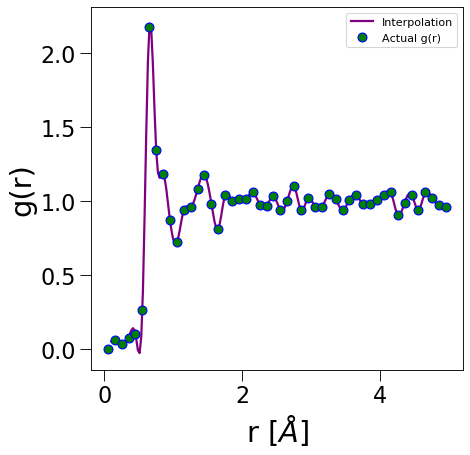

In [7]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r)
plt.plot(xnew, f_cub(xnew), color='purple', linestyle='solid', linewidth=2.0, label='Interpolation') 

# Actual g(r) points
plt.plot(rad_py, g_r_py, 'o', markerfacecolor='green', markersize=8, markeredgecolor='blue', 
         linewidth=2.5, label='Actual g(r)')

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

<div class="alert alert-block alert-info">
    
<h2>Task 1</h2>

Calculate the g(r) for a configuration generated by choosing the minimum distance between the particles to be 1.2 Å. Compare your result with what we have obtained for min_r = 0.6 Å
<div/>

In [8]:
# Set the minimum distance between the particles (as you can see, this is not really a hard sphere liquid! Why?)
min_r = 1.2 # [Å] 

# Generate a random arrangement of particles - according to an algorithm called Poisson sampling.
# Note that every time you run this cell, the algorithm will generate a DIFFERENT configuration!
grid = Grid(min_r, length, width)

# Random seed 
rand = (random.uniform(0, length), random.uniform(0, width))

# Do the sampling
data2 = np.array(grid.poisson(rand))
n_data2=np.array(data2)

pos_x2=np.array(n_data2[:,0])
pos_y2=np.array(n_data2[:,1])


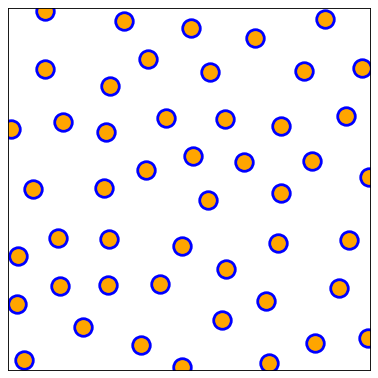

In [9]:
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
# plt.scatter(pos_x,pos_y,s=250, facecolors='blue', edgecolors='orange',linewidth=2.5, label='r_{min}=0.6 Å')
plt.scatter(pos_x2,pos_y2,s=250, facecolors='orange', edgecolors='blue',linewidth=2.5, label='r_{min}=1.2 Å')
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

In [10]:
rad_py2, g_r_py2 = py_rdf(n_data2, length, res_dr, 2)

# We interpolate the result to get a smooth line connecting the dots
res = 200 # How many points do we want in the interpolated line
safe = 1e-1 # Don't you worry about this one...

# We interpolate the g(r) using a cubic spline
f_cub2 = interp1d(rad_py2, g_r_py2, kind='cubic')

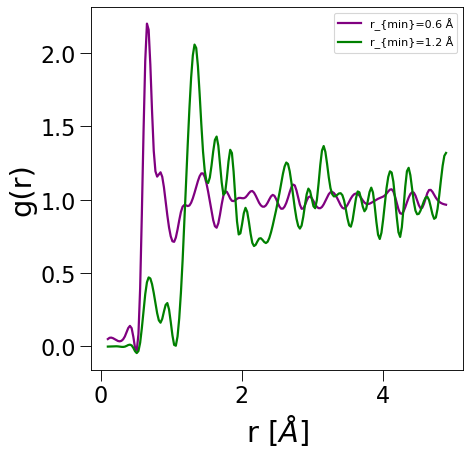

In [11]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r) with r_min=0.6
plt.plot(xnew, f_cub(xnew), color='purple', linestyle='solid', linewidth=2.0, label='r_{min}=0.6 Å') 
# Interpolated g(r) with r_min=1.2
plt.plot(xnew, f_cub2(xnew), color='green', linestyle='solid', linewidth=2.0, label='r_{min}=1.2 Å') 

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

### The need for an ensemble average
As you can see, the g(r) looks a bit "spiky". The reason? Well, we have considered just **one** configuration of our hard sphere liquid! We know that in order to get this right we need to perform an ensemble average, i.e. we have to average our g(r) over different configurations. How? We do a loop! Crucially, every time you call the grid.poisson function, you generate a different configuration - handy!

In [12]:
# This may take a while, check the * in the [] on the left of the cell, when that's gone, you are good to go

n_confs=50 # Number of configurations we are going to take into account

g_r=np.zeros((len(g_r_py),n_confs))
g_r_ave=np.zeros(len(g_r_py))

min_r = 0.6 # [Å] 
grid = Grid(min_r, length, width)
rand = (random.uniform(0, length), random.uniform(0, width))

n_ave=0
for i in range(0,n_confs):
    data = grid.poisson(rand)
    n_data=np.array(data)
    rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)
    g_r[:,i]=g_r_py
    n_ave=n_ave+len(n_data)

# Ensemble average of the g(r)
g_r_ave=(np.sum(g_r, axis=1))/n_confs

# Average number of particles (needed to calculate the coordination number, see below...)
n_ave=n_ave/n_confs

# We interpolate the g(r) using a cubic spline
f_cub_ave = interp1d(rad_py, g_r_ave, kind='cubic')

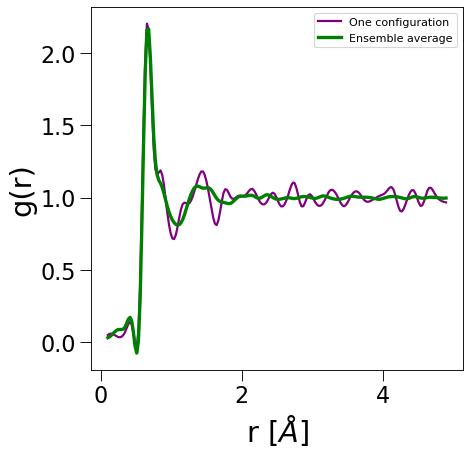

In [13]:
# Comparison of the g(r) for just one configuration and that obtained upon taking an ensemble average
# Let's plot everything for r_min=1.2 [Å]
f_cub_ave = interp1d(rad_py, g_r_ave, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k') # figsize determine the actual size of the figure
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(xnew, f_cub(xnew), color='purple', linestyle='solid', linewidth=2.0, label='One configuration')
plt.plot(xnew, f_cub_ave(xnew), color='green', linestyle='solid', linewidth=3.0, label='Ensemble average')
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.legend()
plt.show()

### The coordination number
Now that we have our (ensemble averaged!) $g(r)$, we can compute the average coordination number $c_N$, which in two dimensions can be calculated from the $g(r)$ as follows: 

$$
c_N(r')_{2D} = 2\pi \rho \int_0^{r'} g(r) r   dr
$$

where $r'$ is a certain "cutoff" distance, meaning that we are going to compute the coordination number up to $r'$. More often than not, we are interested in computing the coordination number up the first coordination shell, which can be visualised as follows:

<img src="STUFF/cn.png" width=500px>


In [14]:
# Integrate the g(r) to get the coordination number
d2dr = rad_py[1]-rad_py[0] # dr
density = n_ave/(length*length) # number density, 2D
r_prime = 1.0 # Å this is our cutoff radius. By looking at our g(r), this is a reasonable guess
cn_2d = 0.0 # initialize the coordination number

for i in range(0,len(rad_py)):
    if rad_py[i] > r_prime: # If r > r', exit the loop
        break
    cn_2d = cn_2d+(g_r_ave[i]*rad_py[i]*d2dr)

cn_2d = cn_2d * (2*np.pi*density)
print("The coordination number is:", cn_2d)

The coordination number is: 5.376089768946308


<div class="alert alert-block alert-info">
    
<h2>Task 2</h2>

    
Compare the average coordination number for two hard sphere liquids obtained by setting ```min_r = 0.6``` and ```min_r = 1.2```, using the same cutoff radius r' = 1.0 Å
<div/>

In [15]:
# Integrate the g(r) to get the coordination number
rad_py2, g_r_py2
d2dr = rad_py2[1]-rad_py2[0] # dr
n_ave = len(pos_x2)
density = n_ave/(length*length) # number density, 2D
r_prime = 1.0 # Å this is our cutoff radius. By looking at our g(r), this is a reasonable guess
cn_2d = 0.0 # initialize the coordination number

for i in range(0,len(rad_py2)):
    if rad_py2[i] > r_prime: # If r > r', exit the loop
        break
    cn_2d = cn_2d+(g_r_py2[i]*rad_py2[i]*d2dr)

cn_2d = cn_2d * (2*np.pi*density)
print("The coordination number is:", cn_2d)

The coordination number is: 0.29166666666666674


### The g(r) for a 3D system
The 3D cased differs from the 2D one exclusively in terms of the normalization factors involved with both the g(r) and the coordination number. In fact, our `py_rdf(r, S, dr, dim)` function is already equipped to deal with the 3D, all we have to do is to specify `dim=3`. For the coordination number, the expression in 3D is:

$$
c_N(r')_{3D} = 4\pi\rho \int_0^{r'} g(r) r^2   dr
$$

In addition, the Poisson-disc sampling algorithm we have been using in the 2D case is already equipped to deal with the 3D case. All we need to do is to specify an extra dimension (the "height" of the box) when calling the `Grid` function. To keep things computationally cheap, we are going to generate a cubic box of edge = 4 Å, with the minimum distance between any two particles equal to 0.5 Å.

In [16]:
tdr=0.5 # r is the minimum distance between any pair of particles
tdlength = 4.0 # length and width are rectangular bounds
tdwidth = tdlength
tdheight = tdwidth
grid = Grid(tdr, tdlength, tdwidth, tdheight) # This might take a while!
rand = (random.uniform(0, tdlength), random.uniform(0, tdwidth), random.uniform(0, tdheight))
tddata = grid.poisson(rand, 30)

In [17]:
np_tddata=np.array(tddata) # Split our data into the x, y and z positions of each particle
pos_x=np.array(np_tddata[:,0])
pos_y=np.array(np_tddata[:,1])
pos_z=np.array(np_tddata[:,2])

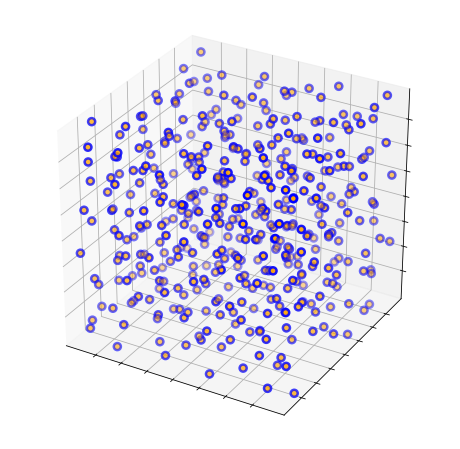

In [18]:
# Let's have a look!
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_x,pos_y,pos_z,s=50, facecolors='orange', edgecolors='blue',linewidth=2.5)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.margins(0,0,0)

In [19]:
tddr=0.05
tdrad, tdg_r = py_rdf(np_tddata,tdlength,tddr,3)
tdf = interp1d(tdrad,tdg_r, kind="cubic")
tdx = np.linspace(safe, (tdlength/2.0)-safe, num=res, endpoint=True)

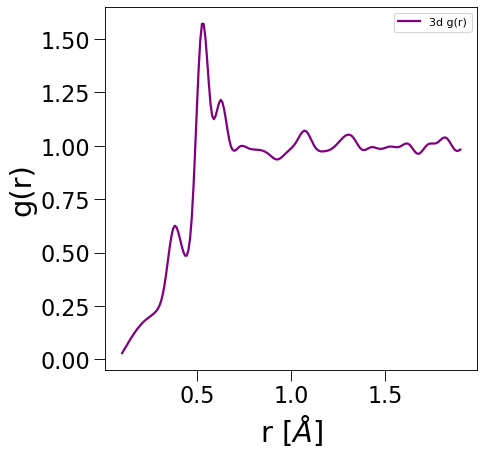

In [20]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated 3D g(r) 
plt.plot(tdx, tdf(tdx), color='purple', linestyle='solid', linewidth=2.0, label="3d g(r)") 


# # Interpolated g(r) with r_min=0.6
# plt.plot(rad_py6, g_r_ave6, color='purple', linestyle='solid', linewidth=2.0, label='r_{min}=0.6 Å') 
# # Interpolated g(r) with r_min=1.2
# plt.plot(rad_py, g_r_ave, color='green', linestyle='solid', linewidth=2.0, label='r_{min}=1.2 Å') 

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

<div class="alert alert-block alert-info">
    
<h2>Task 3</h2>

Calculate the coordination number for our 3D system, up to r' = 1.3 Å
<div/>

In [21]:
# Integrate the g(r) to get the coordination number
d2dr = tdrad[1]-tdrad[0] # dr
n_ave = len(pos_x)
density = n_ave/(length*length*length) # number density, 3D
r_prime = 1.3 # Å this is our cutoff radius. By looking at our g(r), this is a reasonable guess
cn_3d = 0.0 # initialize the coordination number

for i in range(0,len(tdg_r)):
    if tdrad[i] > r_prime: # If r > r', exit the loop
        break
    cn_3d = cn_3d + ((tdrad[i]**2)*tdg_r[i]*d2dr)

cn_3d = cn_3d * (4*np.pi*density)
print("The coordination number is:", cn_3d)

The coordination number is: 4.030988713318286
